## Important

`run_mafft.sh` and `run_raxml.sh` in each subfoloder of `Trees` to build the trees beforehand.

In [1]:
library(ape)
library(sitePath)
library(ggplot2)
library(ggrepel)
library(aplot)
library(RColorBrewer)
suppressPackageStartupMessages(library(treeio))
suppressPackageStartupMessages(library(ggtree))

METADATA_DIR <- "Metadata"
TREES_DIR <- "Trees"
PLOTS_DIR <- "Plots"
STRUCTURES_DIR <- "Structures"

H1N1_HA_NAME <- "H1N1_HA"
H3N2_HA_NAME <- "H3N2_HA"
ZIKV_POLYPROTEIN_NAME <- "ZIKV_polyprotein"
SARS_COV_2_CDS_NAME <- "SARS_CoV_2_cds"

### 1. ZIKV polyprotein

In [2]:
meta <- read.csv(
    file.path(METADATA_DIR, paste0(ZIKV_POLYPROTEIN_NAME, ".tsv")), 
    sep = "\t",
    row.names = "GenBank.Protein.Accession",
    na.strings = c("-N/A-", "Unknown"),
    stringsAsFactors = FALSE
)
rownames(meta) <- sapply(strsplit(rownames(meta), "\\."), "[", 1)
meta <- meta[, colSums(is.na(meta)) < nrow(meta)]

In [3]:
meta[which(meta[["Country"]] == "Taiwan"), ][["Country"]] <- "China"

In [4]:
treeDir <- file.path(TREES_DIR, ZIKV_POLYPROTEIN_NAME)
plotsDir <- file.path(PLOTS_DIR, ZIKV_POLYPROTEIN_NAME)
dir.create(plotsDir, showWarnings = FALSE)

In [5]:
tree <- read.tree(file.path(treeDir, "RAxML_bestTree.PROTGAMMAGTR"))
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

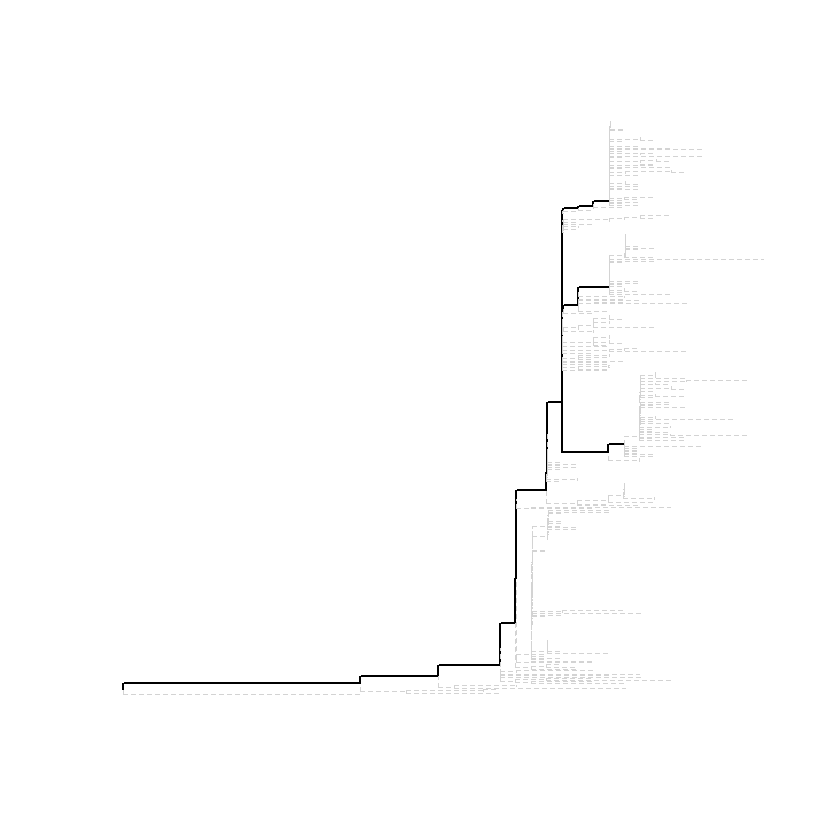

In [6]:
paths <- lineagePath(tree, 0.05)
plot(paths)

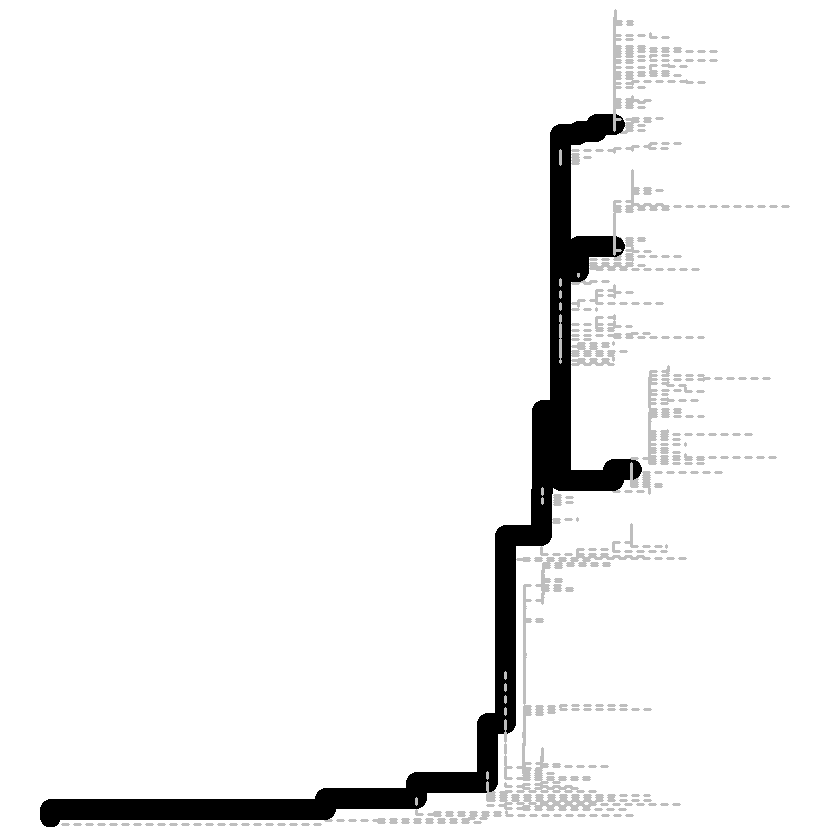

In [10]:
group <- rep(1, times = Ntip(tree) + tree$Nnode)
group[unique(unlist(paths))] <- 0
group <- factor(group)

size <- rep(0.5, times = Ntip(tree) + tree$Nnode)
size[unique(unlist(paths))] <- 1

ggtree(tree, aes(color=group, linetype=group, size = size)) + 
    scale_color_manual(values = c("black", "grey")) + 
    theme(legend.position = "none")

In [7]:
mutations <- fixationSites(paths)

In [8]:
pdf(file = file.path(plotsDir, "sites.pdf"))
for (i in mutations) {
    plot(i)
}
dev.off()

png 
  2

In [9]:
snpTracing <- as.phylo(mutations, minEffectiveSize = 0)
snpTracing[["tip.label"]] <- LETTERS[seq_along(snpTracing[["tip.label"]])]
names(attr(snpTracing, "tipClusters")) <- snpTracing[["tip.label"]]

In [10]:
x <- as_tibble(snpTracing)

d <- as_tibble(t(vapply(
    X = attr(snpTracing, "edgeSNPs"),
    FUN = function (snp) {
        if (length(snp) == 0) {
            res <- NA_character_
        } else {
            res <- character()
            snpNum <- length(snp)
            for (i in seq_len(snpNum)) {
                res <- paste0(res, snp[i])
                if (i < snpNum) {
                    if (i %% 4 == 0) {
                        res <- paste0(res, ",\n")
                    } else {
                        res <- paste0(res, ", ")
                    }
                }
            }

        }
        res <- c(res, attr(snp, "edge")[2])
        names(res) <- c("SNPs", "node")
        return(res)
    }, 
    FUN.VALUE = c(character(1), integer(1))
)))

d[["node"]] <- as.integer(d[["node"]])

y <- full_join(x, d, by = "node")
tr <- as.treedata(y)

checkValidPhylo(tr@phylo)

Starting checking the validity of tr@phylo...
Found number of tips: n = 15 
Found number of nodes: m = 7 
Done.


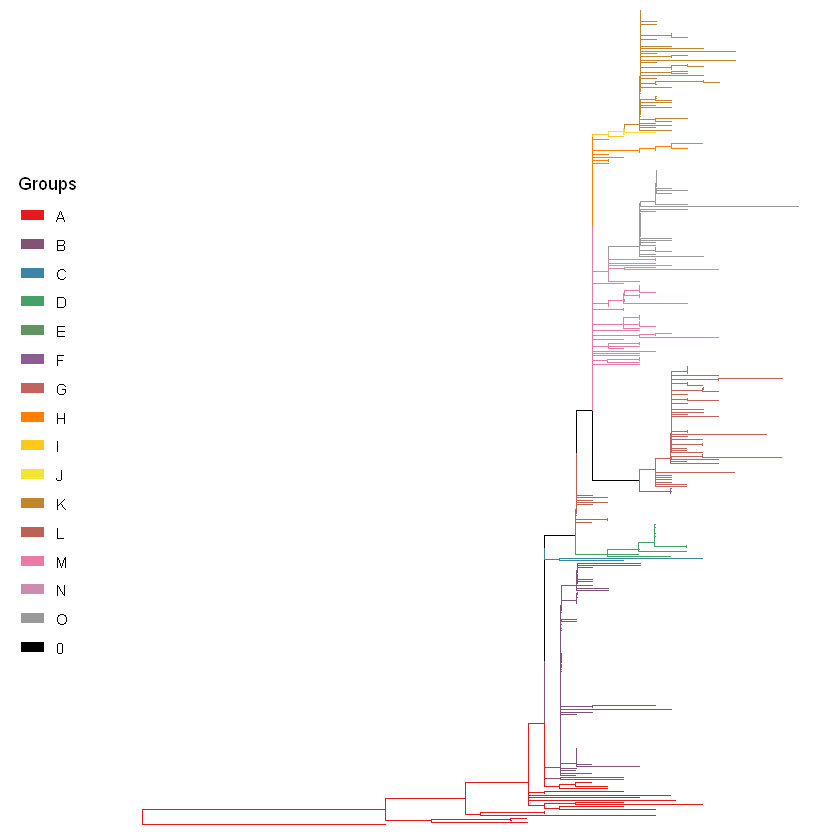

In [11]:
group <- attr(snpTracing, "tipClusters")

groupColors <- colorRampPalette(brewer.pal(9, "Set1"))(length(group))
names(groupColors) <- names(group)
groupColors["0"] <- "#000000"

p <- ggtree(groupOTU(tree, group, group_name = "color"), aes(color = color)) +
    scale_color_manual(values = as.list(groupColors), limits = names(groupColors)) +
    guides(
      color = guide_legend(
        override.aes = list(size = 3),
        title = 'Groups'
      )
    ) +
    theme(legend.position = "left")
p

ggsave(
    filename = file.path(plotsDir, "cluster.pdf"), 
    plot = p,
    width = 10,
    height = 8
)

In [12]:
clusterPaths <- list()
rootNode <- getMRCA(tree, tree[["tip.label"]])

for (cluster in names(group)) {
    tips <- group[[cluster]]
    ancestral <- getMRCA(tree, tips)
    if (is.null(ancestral)) {
        np <- nodepath(tree, rootNode, tips)
        clusterPaths[[cluster]] <- np[1:(length(np) - 1)]
    } else {
        clusterPaths[[cluster]] <- nodepath(tree, rootNode, ancestral)
    }
}

In [13]:
clusterInfo <- lapply(names(group), function(g) {
    data.frame(row.names = group[[g]], "cluster" = rep(g, length(group[[g]])))
})
clusterInfo <- do.call(rbind, clusterInfo)

In [14]:
transMut <- list()

for (sp in mutations) {
    site <- attr(sp, "site")
    for (mp in sp) {
        for (i in seq_along(mp)[-1]) {
            prevTips <- mp[[i - 1]]
            currTips <- mp[[i]]
            prevAA <- attr(prevTips, "AA")
            currAA <- attr(currTips, "AA")
            mutation <- paste0(prevAA, site, currAA)
            prevCluster <- unique(clusterInfo[as.character(prevTips), ])
            names(prevCluster) <- prevCluster
            prev <- names(which.max(lapply(prevCluster, function(cluster) {
                length(clusterPaths[[cluster]])
            })))
            currCluster <- unique(clusterInfo[as.character(currTips), ])
            names(currCluster) <- currCluster
            curr <- names(which.min(lapply(currCluster, function(cluster) {
                length(clusterPaths[[cluster]])
            })))
            trans <- paste(prev, curr, sep = "-")
            if (trans %in% names(transMut)) {
                transMut[[trans]] <- c(transMut[[trans]], mutation)
            } else {
                transMut[[trans]] <- mutation
            }
        }
    }
}

transMut <- lapply(transMut, unique)

In [15]:
pred <- lapply(names(transMut), function(i) {
    c(i, paste(transMut[[i]], collapse = ","))
})
pred <- do.call(rbind, pred)
colnames(pred) <- c("Transition", "Mutations")

In [16]:
pred <- lapply(names(transMut), function(i) {
    c(i, paste(transMut[[i]], collapse = ","))
})
pred <- do.call(rbind, pred)
colnames(pred) <- c("Transition", "Mutations")
write.csv(pred, file.path(plotsDir, "sitePath.csv"), row.names = FALSE)

In [17]:
countryData <- lapply(seq_along(snpTracing[["tip.label"]]), function(i) {
    tipName <- LETTERS[i]
    i <- attr(snpTracing, "tipClusters")[[i]]
    data.frame(
        "tip" = tipName,
        "Country" = meta[tree$tip.label[i], "Country"]
    )
})
countryData <- do.call(rbind, countryData)

In [18]:
df <- lapply(split(countryData, countryData[["Country"]]), function(i) {
    res <- reshape2::dcast(i, tip ~ Country, value.var = "Country", length)
    names(res)[2] <- "Num"
    res[["Country"]] <- unique(i[["Country"]])
    res
})
df <- do.call(rbind, df)

df <- df[order(df[["tip"]]), ]

df <- lapply(split(df, df[["tip"]]), function(i) {
    i[["Pos"]] <- cumsum(i[["Num"]]) - (0.5 * i[["Num"]])
    i
})
df <- do.call(rbind, df)
rownames(df) <- NULL

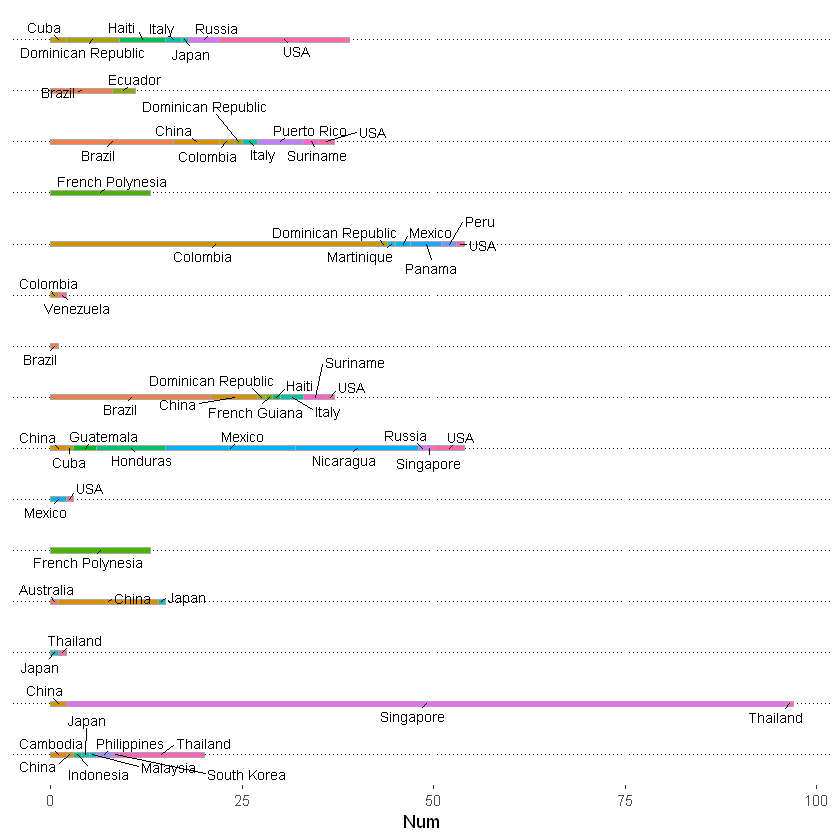

In [19]:
p1 <- ggplot(df, aes(x = Num, y = tip, fill = Country)) + 
    geom_bar(colour="#A9A9A9", stat="identity", position = position_stack(reverse = TRUE), width = 0.1) +
    geom_text_repel(
        aes(label=Country, x = Pos), 
        size = 3,
        min.segment.length = 0.1,
#         box.padding = 0.2,
#         direction = "y",
#         vjust = 1
    ) +
    theme(
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid.major.y = element_line(colour = "black", linetype = 3),
        legend.position = "none"
    )
p1

Saving 14 x 6.67 in image



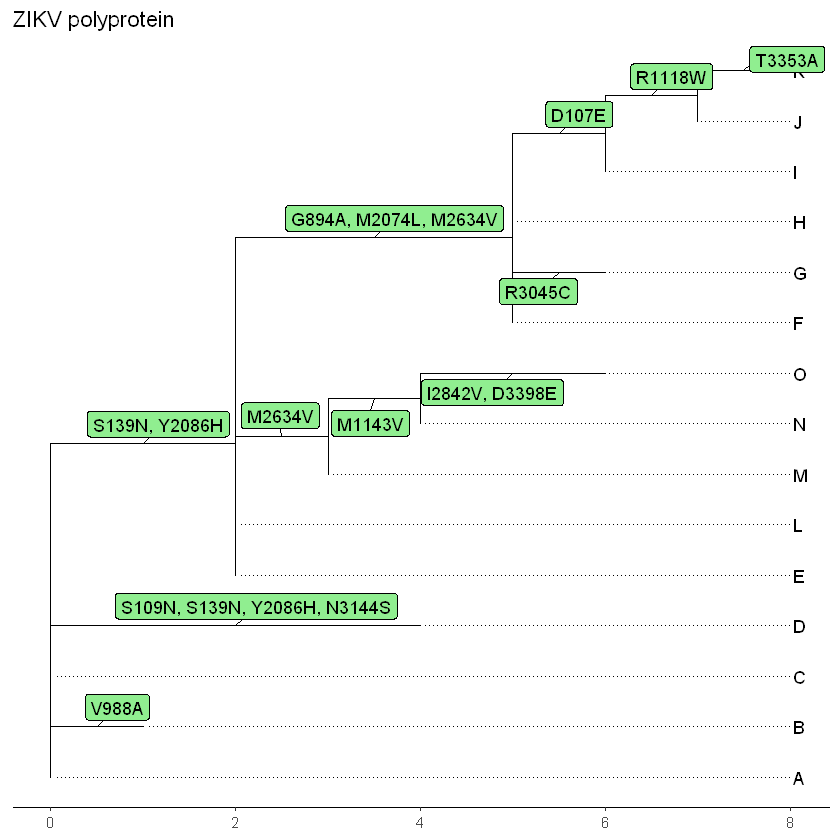

In [20]:
p <- ggtree(tr) + geom_tiplab(align = TRUE) +
    geom_label_repel(
        aes(x=branch, label=SNPs), 
        fill='lightgreen', 
        min.segment.length = 0,
        na.rm = TRUE
    ) +
    theme_tree2() +
    ggtitle("ZIKV polyprotein")
p

p <- p1 %>% insert_left(p)
# p

ggsave(filename = file.path(plotsDir, "snpTracing.pdf"), plot = p, width = 14)

### 2. SARS-CoV-2 CDS

In [21]:
meta <- read.csv(
    file.path(METADATA_DIR, paste0(SARS_COV_2_CDS_NAME, ".csv")), 
    row.names = "Accession.ID",
    stringsAsFactors = FALSE
)

In [22]:
treeDir <- file.path(TREES_DIR, SARS_COV_2_CDS_NAME)
plotsDir <- file.path(PLOTS_DIR, SARS_COV_2_CDS_NAME)
dir.create(plotsDir, showWarnings = FALSE)

In [23]:
tree <- read.tree(file.path(treeDir, "RAxML_bestTree.GTRGAMMA"))
tree <- addMSA(tree, msaPath = file.path(treeDir, "aligned.fasta"), msaFormat = "fasta")

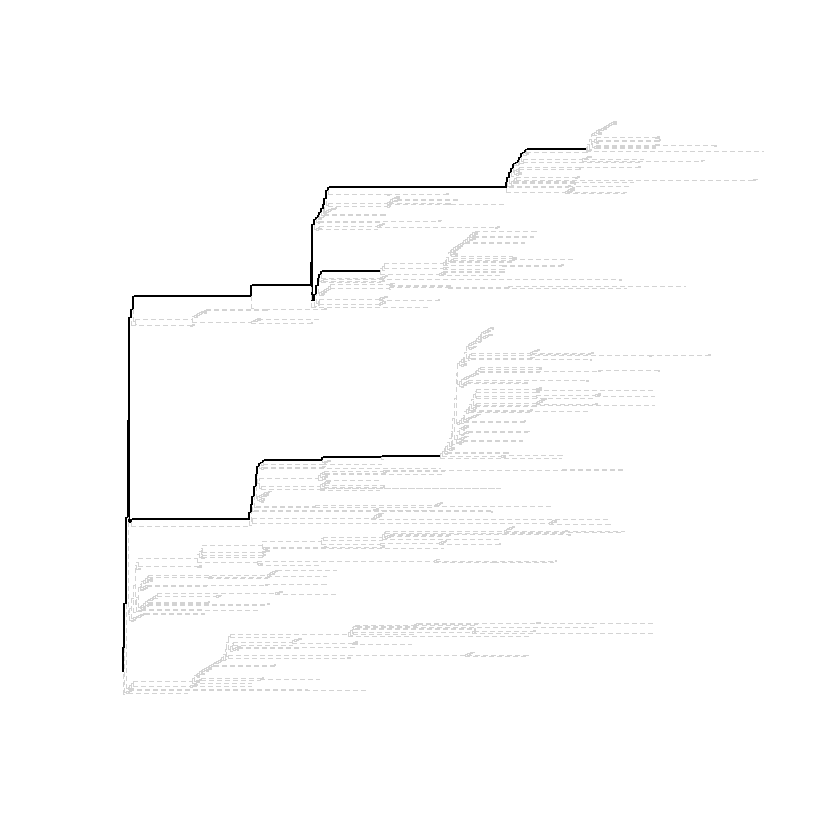

In [24]:
paths <- lineagePath(tree, similarity = 0.03)
plot(paths)

In [25]:
mutations <- fixationSites(paths)

In [26]:
pdf(file = file.path(plotsDir, "sites.pdf"))
for (i in mutations) {
    plot(i)
}
dev.off()

png 
  2

In [27]:
snpTracing <- as.phylo(mutations, minEffectiveSize = 0)
snpTracing[["tip.label"]] <- LETTERS[seq_along(snpTracing[["tip.label"]])]
names(attr(snpTracing, "tipClusters")) <- snpTracing[["tip.label"]]

In [28]:
x <- as_tibble(snpTracing)

d <- as_tibble(t(vapply(
    X = attr(snpTracing, "edgeSNPs"),
    FUN = function (snp) {
        if (length(snp) == 0) {
            res <- NA_character_
        } else {
            res <- character()
            snpNum <- length(snp)
            for (i in seq_len(snpNum)) {
                res <- paste0(res, snp[i])
                if (i < snpNum) {
                    if (i %% 4 == 0) {
                        res <- paste0(res, ",\n")
                    } else {
                        res <- paste0(res, ", ")
                    }
                }
            }

        }
        res <- c(res, attr(snp, "edge")[2])
        names(res) <- c("SNPs", "node")
        return(res)
    }, 
    FUN.VALUE = c(character(1), integer(1))
)))

d[["node"]] <- as.integer(d[["node"]])

y <- full_join(x, d, by = "node")
tr <- as.treedata(y)

checkValidPhylo(tr@phylo)

Starting checking the validity of tr@phylo...
Found number of tips: n = 15 
Found number of nodes: m = 7 
Done.


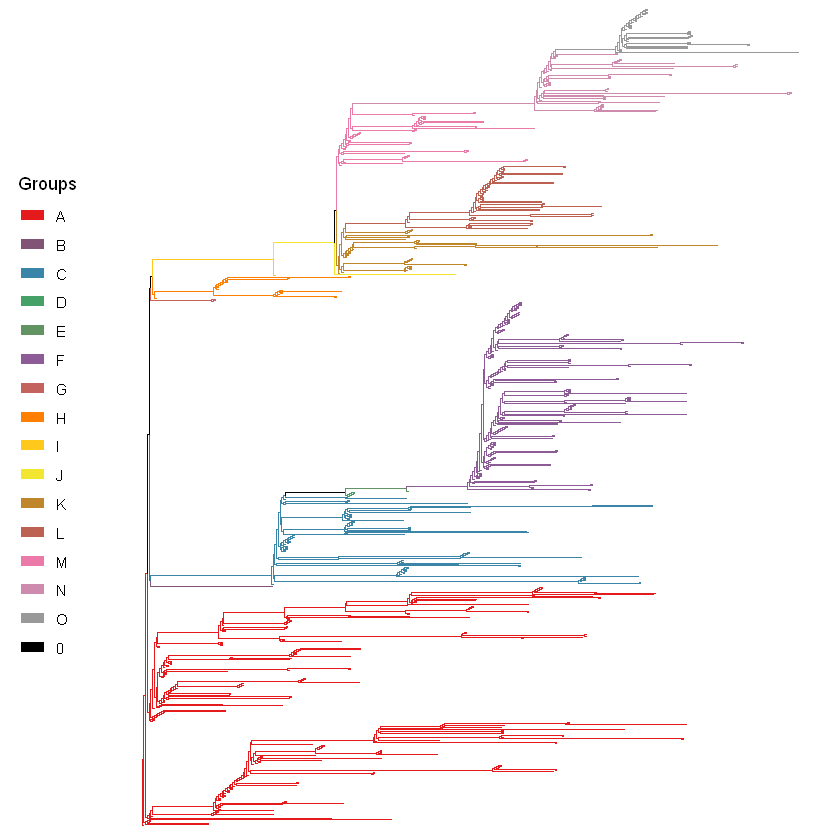

In [29]:
group <- attr(snpTracing, "tipClusters")

groupColors <- colorRampPalette(brewer.pal(9, "Set1"))(length(group))
names(groupColors) <- names(group)
groupColors["0"] <- "#000000"

p <- ggtree(groupOTU(tree, group, group_name = "color"), aes(color = color)) +
    scale_color_manual(values = as.list(groupColors), limits = names(groupColors)) +
    guides(
      color = guide_legend(
        override.aes = list(size = 3),
        title = 'Groups'
      )
    ) +
    theme(legend.position = "left")
p

ggsave(
    filename = file.path(plotsDir, "cluster.pdf"), 
    plot = p,
    width = 10,
    height = 8
)

In [30]:
clusterPaths <- list()
rootNode <- getMRCA(tree, tree[["tip.label"]])

for (cluster in names(group)) {
    tips <- group[[cluster]]
    ancestral <- getMRCA(tree, tips)
    if (is.null(ancestral)) {
        np <- nodepath(tree, rootNode, tips)
        clusterPaths[[cluster]] <- np[1:(length(np) - 1)]
    } else {
        clusterPaths[[cluster]] <- nodepath(tree, rootNode, ancestral)
    }
}

In [31]:
clusterInfo <- lapply(names(group), function(g) {
    data.frame(row.names = group[[g]], "cluster" = rep(g, length(group[[g]])))
})
clusterInfo <- do.call(rbind, clusterInfo)

In [32]:
transMut <- list()

for (sp in mutations) {
    site <- attr(sp, "site")
    for (mp in sp) {
        for (i in seq_along(mp)[-1]) {
            prevTips <- mp[[i - 1]]
            currTips <- mp[[i]]
            prevAA <- attr(prevTips, "AA")
            currAA <- attr(currTips, "AA")
            mutation <- paste0(prevAA, site, currAA)
            prevCluster <- unique(clusterInfo[as.character(prevTips), ])
            names(prevCluster) <- prevCluster
            prev <- names(which.max(lapply(prevCluster, function(cluster) {
                length(clusterPaths[[cluster]])
            })))
            currCluster <- unique(clusterInfo[as.character(currTips), ])
            names(currCluster) <- currCluster
            curr <- names(which.min(lapply(currCluster, function(cluster) {
                length(clusterPaths[[cluster]])
            })))
            trans <- paste(prev, curr, sep = "-")
            if (trans %in% names(transMut)) {
                transMut[[trans]] <- c(transMut[[trans]], mutation)
            } else {
                transMut[[trans]] <- mutation
            }
        }
    }
}

transMut <- lapply(transMut, unique)

In [33]:
pred <- lapply(names(transMut), function(i) {
    c(i, paste(transMut[[i]], collapse = ","))
})
pred <- do.call(rbind, pred)
colnames(pred) <- c("Transition", "Mutations")

In [34]:
pred <- lapply(names(transMut), function(i) {
    c(i, paste(transMut[[i]], collapse = ","))
})
pred <- do.call(rbind, pred)
colnames(pred) <- c("Transition", "Mutations")
write.csv(pred, file.path(plotsDir, "sitePath.csv"), row.names = FALSE)

In [35]:
countryData <- lapply(attr(snpTracing, "tipClusters"), function(i) {
    data.frame(
        "tip" = as.character(length(i)),
        "Country" = meta[tree$tip.label[i], "Country"]
    )
})
countryData <- do.call(rbind, countryData)

In [36]:
df <- lapply(split(countryData, countryData[["Country"]]), function(i) {
    res <- reshape2::dcast(i, tip ~ Country, value.var = "Country", length)
    names(res)[2] <- "Num"
    res[["Country"]] <- unique(i[["Country"]])
    res
})
df <- do.call(rbind, df)

df <- df[order(df[["tip"]]), ]

df <- lapply(split(df, df[["tip"]]), function(i) {
    i[["Pos"]] <- cumsum(i[["Num"]]) - (0.5 * i[["Num"]])
    i
})
df <- do.call(rbind, df)
rownames(df) <- NULL

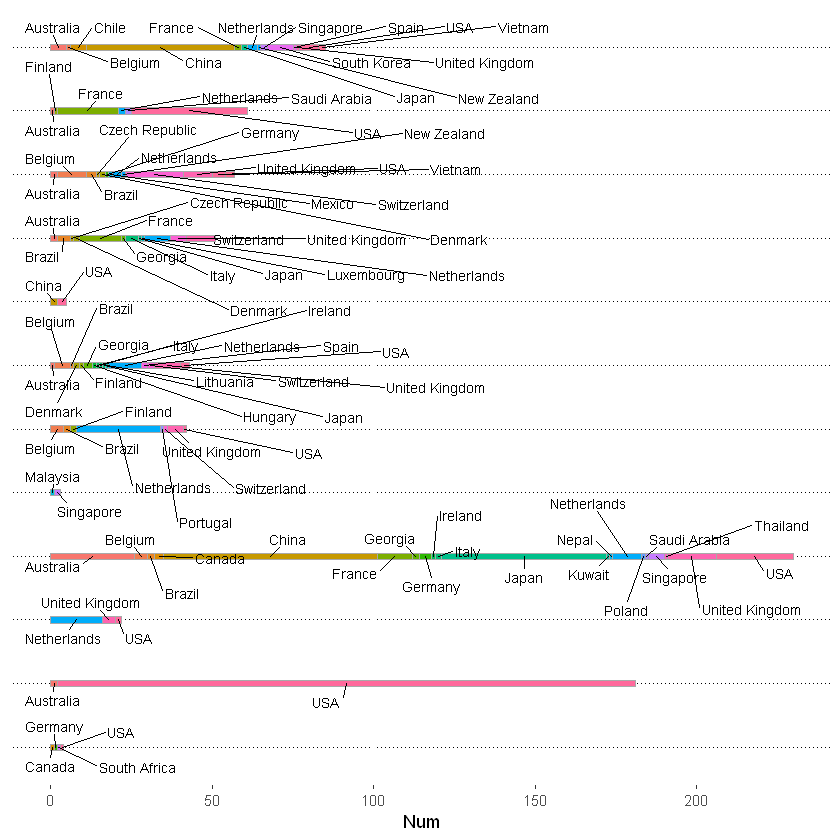

In [37]:
p1 <- ggplot(df, aes(x = Num, y = tip, fill = Country)) + 
    geom_bar(colour="#A9A9A9", stat="identity", position = position_stack(reverse = TRUE), width = 0.1) +
    geom_text_repel(
        aes(label=Country, x = Pos), 
        size = 3, 
        min.segment.length = 0.1,
        box.padding = 0.5
    ) +
    theme(
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank(),
        panel.background = element_rect(fill = "white"),
        panel.grid.major.y = element_line(colour = "black", linetype = 3),
        legend.position = "none"
    )
p1

Saving 14 x 6.67 in image



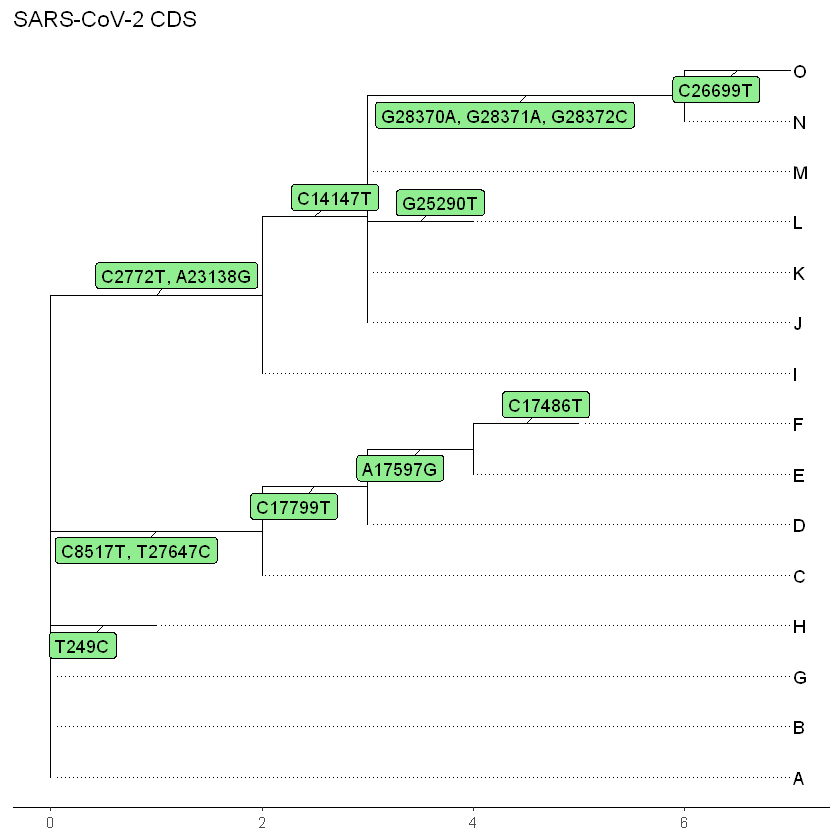

In [38]:
p <- ggtree(tr) + geom_tiplab(align = TRUE) +
    geom_label_repel(aes(x=branch, label=SNPs), fill='lightgreen', min.segment.length = 0, na.rm = TRUE) + 
    theme_tree2() +
    ggtitle("SARS-CoV-2 CDS")
p

p <- p1 %>% insert_left(p)
# p 

ggsave(filename = file.path(plotsDir, "snpTracing.pdf"), plot = p, width = 14)